所有的代码都是参考于:https://huggingface.co/docs/transformers/tasks/object_detection

In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101")


inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

d:\anaconda3\envs\huggingface\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]


In [4]:
import json
import os
from PIL import Image
from typing import List, Dict, Any
from datasets import Dataset, DatasetDict

def read_coco_dataset(dataset_dir: str) -> DatasetDict:
    dataset_dict = {}
    for split in ["train", "valid", "test"]:
        image_dir = os.path.join(dataset_dir, split, "images")
        annotation_file = os.path.join(dataset_dir, split, "_annotations.coco.json")
        with open(annotation_file, "r") as f:
            annotations = json.load(f)
        
        image_id_to_filename = {}
        for image in annotations["images"]:
            image_id_to_filename[image["id"]] = os.path.join(image_dir, image["file_name"])
        
        records = []
        for annotation in annotations["annotations"]:
            image_id = annotation["image_id"]
            filename = image_id_to_filename[image_id]
            bbox = annotation["bbox"]
            x, y, w, h = bbox
            category_id = annotation["category_id"]
            area = annotation["area"]
            record = {
                "image_id": image_id,
                "image": Image.open(filename),
                "width": w,
                "height": h,
                "objects": {
                    "id": [annotation["id"]],
                    "area": [area],
                    "bbox": [[x, y, w, h]],
                    "category": [category_id]
                }
            }
            records.append(record)
        
        dataset = Dataset.from_dict({"image_id": [r["image_id"] for r in records],
                                     "image": [r["image"] for r in records],
                                     "width": [r["width"] for r in records],
                                     "height": [r["height"] for r in records],
                                     "objects": [r["objects"] for r in records]})
        dataset_dict[split] = dataset
    return DatasetDict(dataset_dict)

In [5]:
cppe5 = read_coco_dataset("./data/test-strip-head.v3i.coco")
print(cppe5)
print(cppe5["train"][0])

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 134
    })
    valid: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 16
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 10
    })
})
{'image_id': 0, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x1FFA2A74E50>, 'width': 49, 'height': 72, 'objects': {'area': [3528], 'bbox': [[41, 125, 49, 72]], 'category': [1], 'id': [0]}}


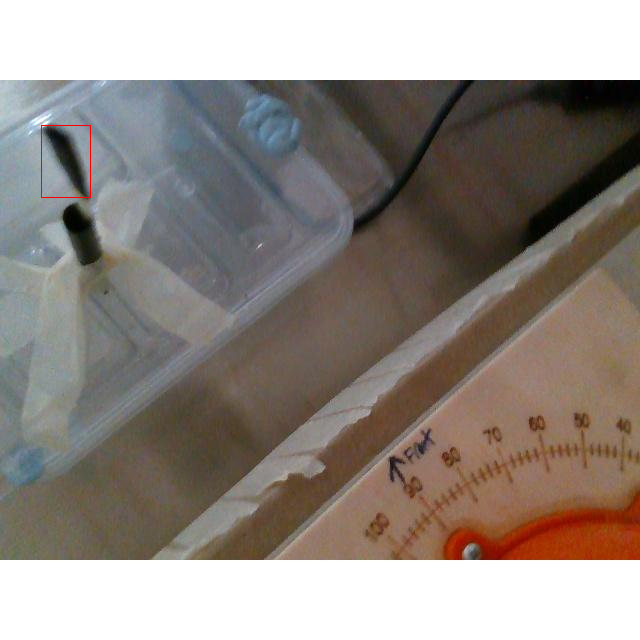

In [8]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

#categories = cppe5["train"].features["objects"].feature["category"].names

#id2label = {index: x for index, x in enumerate(categories, start=0)}
#label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    # draw.text((x, y), id2label[class_idx], fill="white")

image

In [10]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101")

In [12]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [13]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [14]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [15]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]



d:\anaconda3\envs\huggingface\lib\site-packages\transformers\models\detr\image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


{'pixel_values': tensor([[[ 1.6495,  1.6495,  1.6495,  ...,  1.5982, -0.6281, -2.1179],
          [ 1.6495,  1.6495,  1.6495,  ...,  1.5982, -0.6281, -2.1179],
          [ 1.6495,  1.6495,  1.6495,  ...,  1.6153, -0.6281, -2.1179],
          ...,
          [ 1.6495,  1.6495,  1.6495,  ...,  1.6153, -0.6281, -2.1179],
          [ 1.6495,  1.6495,  1.6495,  ...,  1.5982, -0.6281, -2.1179],
          [ 1.6495,  1.6495,  1.6495,  ...,  1.5982, -0.6281, -2.1179]],
 
         [[ 1.8158,  1.8158,  1.8158,  ...,  1.7633, -0.5126, -2.0357],
          [ 1.8158,  1.8158,  1.8158,  ...,  1.7633, -0.5126, -2.0357],
          [ 1.8158,  1.8158,  1.8158,  ...,  1.7808, -0.5126, -2.0357],
          ...,
          [ 1.8158,  1.8158,  1.8158,  ...,  1.7808, -0.5126, -2.0357],
          [ 1.8158,  1.8158,  1.8158,  ...,  1.7633, -0.5126, -2.0357],
          [ 1.8158,  1.8158,  1.8158,  ...,  1.7633, -0.5126, -2.0357]],
 
         [[ 2.0300,  2.0300,  2.0300,  ...,  1.9777, -0.2881, -1.8044],
          [ 

In [16]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [17]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-101")

In [21]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
)

trainer.train()

d:\anaconda3\envs\huggingface\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/170 [00:00<?, ?it/s]

d:\anaconda3\envs\huggingface\lib\site-packages\transformers\models\detr\image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB (GPU 0; 8.00 GiB total capacity; 7.15 GiB already allocated; 0 bytes free; 7.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF